# Compose: Training a model to generate music

In [1]:
import os
import pickle
import numpy
import pydot
from matplotlib import pyplot
from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model
from keras import regularizers

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

Using TensorFlow backend.


## Set parameters

In [2]:
# run params
section = 'compose'
run_id = '0006'
genre_name = 'jazz'
composer_name='CharlieParker'

run_folder = 'run/{}/{}/'.format(section, genre_name)
run_folder += '_'.join([run_id, composer_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', genre_name, composer_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True
#reg = None
reg = regularizers.l2(0.01)

## Extract the notes

In [3]:
data_folder

'data/jazz/CharlieParker'

In [4]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            #notes.extend(['START'] * seq_len)
            #durations.extend([0]* seq_len)
            notes.extend(['START'])
            durations.extend([0])

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f)
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f) 

15 files in total
1 Parsing data/jazz/CharlieParker/CharlieParker_ThrivingOnARiff_FINAL.mid
2 Parsing data/jazz/CharlieParker/CharlieParker_OutOfNowhere_FINAL.mid
3 Parsing data/jazz/CharlieParker/CharlieParker_YardbirdSuite_FINAL.mid
4 Parsing data/jazz/CharlieParker/CharlieParker_DonnaLee_FINAL.mid
5 Parsing data/jazz/CharlieParker/CharlieParker_K.C.Blues_FINAL.mid
6 Parsing data/jazz/CharlieParker/CharlieParker_Ornithology_FINAL.mid
7 Parsing data/jazz/CharlieParker/CharlieParker_Steeplechase_FINAL.mid
8 Parsing data/jazz/CharlieParker/CharlieParker_Segment_FINAL.mid
9 Parsing data/jazz/CharlieParker/CharlieParker_StarEyes_FINAL.mid
10 Parsing data/jazz/CharlieParker/CharlieParker_EmbraceableYou_FINAL.mid
11 Parsing data/jazz/CharlieParker/CharlieParker_HowDeepIsTheOcean_FINAL.mid
12 Parsing data/jazz/CharlieParker/CharlieParker_MyLittleSuedeShoes_FINAL.mid
13 Parsing data/jazz/CharlieParker/CharlieParker_BluesForAlice_FINAL.mid
14 Parsing data/jazz/CharlieParker/CharlieParker_Ko=Ko

## Create the lookup tables

In [5]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
#velocity_names, n_velocities = get_distinct(velocities)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
#velocity_to_int, int_to_velocity = create_lookups(velocity_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [6]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A3': 0,
 'A3.B-3': 1,
 'A3.B-3.C4': 2,
 'A3.B3': 3,
 'A3.C#4': 4,
 'A3.C4': 5,
 'A3.D4': 6,
 'A3.F#4': 7,
 'A3.F4': 8,
 'A3.G4': 9,
 'A4': 10,
 'A4.B-4': 11,
 'A4.B4': 12,
 'A4.C#5': 13,
 'A4.C5': 14,
 'A4.D5': 15,
 'A4.G5': 16,
 'B-3': 17,
 'B-3.B3': 18,
 'B-3.C#4': 19,
 'B-3.C4': 20,
 'B-3.C4.C#4': 21,
 'B-3.D4': 22,
 'B-3.E-4': 23,
 'B-3.E4': 24,
 'B-3.F4': 25,
 'B-4': 26,
 'B-4.B4': 27,
 'B-4.C#5': 28,
 'B-4.C5': 29,
 'B-4.D5': 30,
 'B-4.E-5': 31,
 'B3': 32,
 'B3.C#4': 33,
 'B3.C#4.F#4': 34,
 'B3.C4': 35,
 'B3.C4.D4': 36,
 'B3.C4.E4': 37,
 'B3.D4': 38,
 'B3.D4.E4': 39,
 'B3.E4': 40,
 'B3.E4.F4': 41,
 'B3.F#4': 42,
 'B3.G#4': 43,
 'B4': 44,
 'B4.C#5': 45,
 'B4.C5': 46,
 'B4.C5.E-5.E5': 47,
 'B4.D5': 48,
 'B4.D5.E5': 49,
 'B4.E-5': 50,
 'B4.E5': 51,
 'C#4': 52,
 'C#4.A4': 53,
 'C#4.D4': 54,
 'C#4.E-4': 55,
 'C#4.E4': 56,
 'C#4.E4.F4': 57,
 'C#4.F#4': 58,
 'C#4.F4': 59,
 'C#4.G4': 60,
 'C#5': 61,
 'C#5.D5': 62,
 'C#5.E-5': 63,
 'C#5.E-5.E5': 64,
 'C#5.E5': 65,
 'C#5.F5': 66,
 'C4': 

In [7]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(7, 12): 7,
 Fraction(2, 3): 8,
 0.75: 9,
 Fraction(5, 6): 10,
 Fraction(11, 12): 11,
 1.0: 12,
 Fraction(13, 12): 13,
 Fraction(7, 6): 14,
 1.25: 15,
 Fraction(4, 3): 16,
 Fraction(17, 12): 17,
 1.5: 18,
 Fraction(19, 12): 19,
 Fraction(5, 3): 20,
 1.75: 21,
 Fraction(11, 6): 22,
 Fraction(23, 12): 23,
 2.0: 24,
 Fraction(25, 12): 25,
 Fraction(13, 6): 26,
 2.25: 27,
 Fraction(7, 3): 28,
 2.5: 29,
 Fraction(31, 12): 30,
 Fraction(8, 3): 31,
 2.75: 32,
 Fraction(35, 12): 33,
 Fraction(19, 6): 34,
 3.25: 35,
 Fraction(10, 3): 36,
 7.75: 37}

## Prepare the sequences used by the Neural Network

In [8]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [9]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[197  89 104 117 148  89 104 148  89  67  20  17  67  17   0   1  17  89
 148  10 169 187 133 148 117 104   0  89  67  17   0 160]
duration input
[ 0  3  3  3  9  3  6  6  6  5  1  7 12  6  3  1  3  6  6  4  6  6  4  8
  4  6  9  8  6  6  4  4]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
duration output
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

## Create the structure of the neural network

In [10]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention, reg)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    19800       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 100)    3800        input_2[0][0]                    
____________________________________________________________________________________________

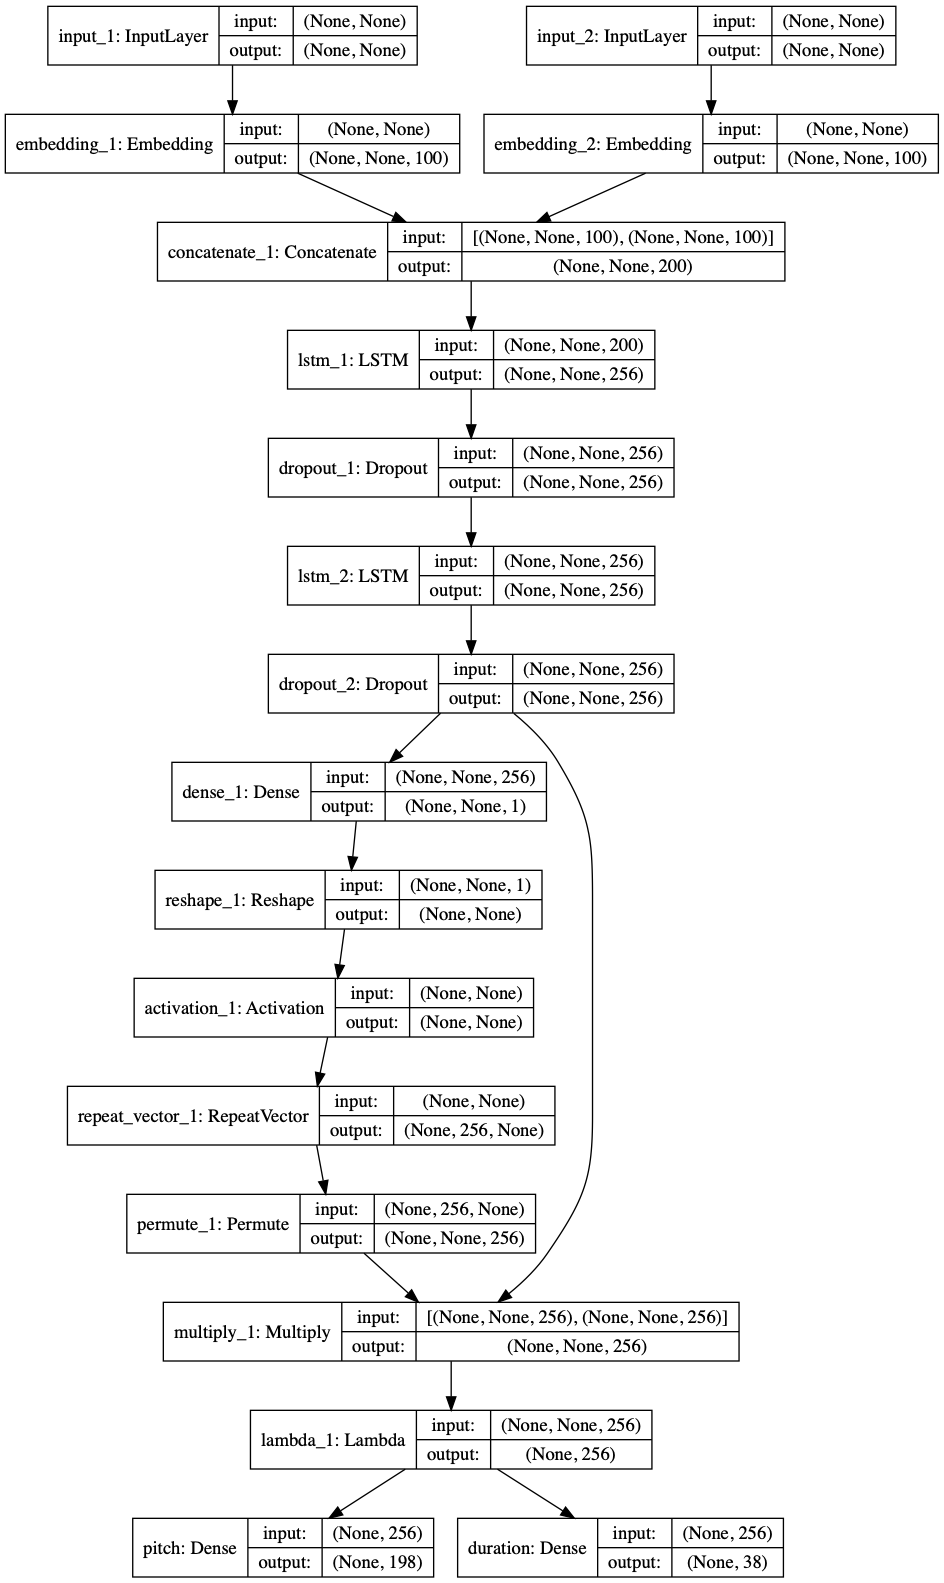

In [11]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

## Train the neural network

In [12]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
history = model.fit(network_input, network_output
          , epochs=20000, batch_size=32
          , validation_split = 0.3
          , callbacks=callbacks_list
          , shuffle=True
         )

train_history = history.history['loss']
val_history = history.history['val_loss']


/Users/weiliang/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 3648 samples, validate on 1564 samples
Epoch 1/20000
3648/3648 [==============================] - 101s 28ms/step - loss: 13.7110 - pitch_loss: 5.0949 - duration_loss: 3.3445 - val_loss: 12.1360 - val_pitch_loss: 4.8250 - val_duration_loss: 3.0183
Epoch 2/20000
3648/3648 [==============================] - 85s 23ms/step - loss: 11.2592 - pitch_loss: 4.5847 - duration_loss: 2.6910 - val_loss: 10.3964 - val_pitch_loss: 4.3375 - val_duration_loss: 2.5013
Epoch 3/20000
3648/3648 [==============================] - 92s 25ms/step - loss: 9.7568 - pitch_loss: 4.2590 - duration_loss: 2.3546 - val_loss: 9.1032 - val_pitch_loss: 4.1033 - val_duration_loss: 2.3152
Epoch 4/20000
3648/3648 [==============================] - 91s 25ms/step - loss: 8.6429 - pitch_loss: 4.1003 - duration_loss: 2.2272 - val_loss: 8.1390 - val_pitch_loss: 3.9796 - val_duration_loss: 2.2419
Epoch 5/20000
3648/3648 [==============================] - 81s 22ms/step - loss: 7.7985 - pitch_loss: 4.0164 - duration_loss: 2

In [ ]:
pyplot.plot(train_history, color='blue', label='train')
pyplot.plot(val_history, color='orange', label='validation')
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower left')
pyplot.show()